# Collaborating via Featureform: ECommerce Example

In this notebook we'll show you an end-to-end example of how to use a Virtual Feature Store (like Featureform) as part of the data science workflow on a [real commercial dataset of 100k orders](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_orders_dataset.csv). 


Specifically, we'll show how two data scientists (Tim & Karl) can create, collaborate, and extend features & training sets using Featureform.

---


## 🎯 `Most Important Takeaways`

Specifically you'll see examples of:

*   ✅ How to connect to providers like AWS, EMR, Redis, & Spark

*   ✅ How to connect to different Parquet files as sources 

*   ✅ Writing transformations using Spark SQL & Spark Datafram operations

*   ✅ Chaining transformations as DAGs & using curly bracket notation to reference different versions of sources & transformations

*   ✅ Creating different variants of features & training sets & zipping them up 

*   ✅ "Write once, serve twice" - Serving features for training & for production inference is as simple as providing a key & specifying whichh model & set of features you'd like to use for specific entities 

*   ✅ How using `get` functions, data scientists that want to connect to & use existing features & training sets can do so with minimal setup.


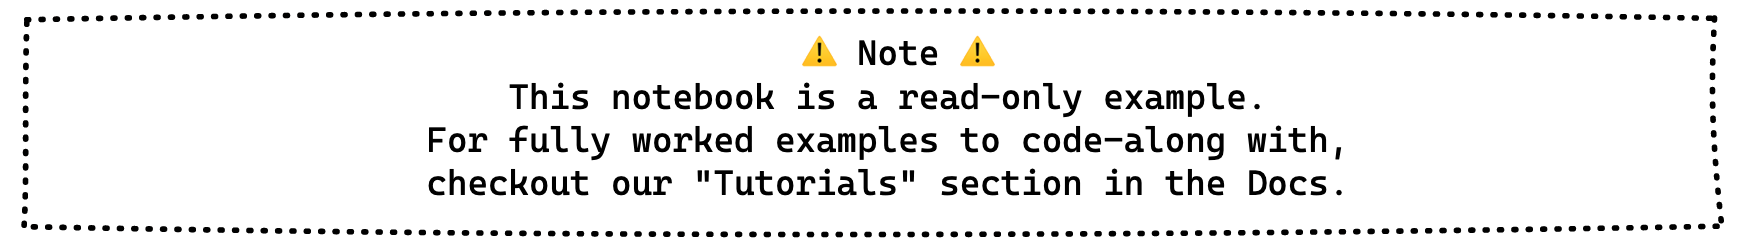

spaces_7zjTL7ABcD1n7YpHH1oe_uploads_git-blob-9cdcb81cd51441fb9379d668a5346e0395743803_Chain-1 (2).svg

# ➡️ Pre-Reqs

**Mount GDrive**

The Google Drive will be used to access the credential files for AWS (S3 + EMR), Redis. Make sure you have your credentials file in your drive under *credentials* folder. You will be asked to give access to mount your drive. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Verify that the credential files are accessible. Make sure you've created a shortcut to the '_credentials' folder in your GDrive.

In [ ]:
!ls ./drive/Drive/credentials/credentials/

aws_info.env  azure_redisent.env      bigquery.json
azure.env     azure_redis_paired.env  firestore.json


In [ ]:
!pip3 -q install python-dotenv

In [ ]:
import os
from dotenv import load_dotenv
#Insert path to credentials file
load_dotenv(dotenv_path='/content/drive/Drive/credentials/aws_info.env')

True

In [ ]:
AWS_ACCESS_KEY_ID =  os.getenv('AWS_ACCESS_KEY_ID')
AWS_SECRET_KEY = os.getenv('AWS_SECRET_KEY')
S3_BUCKET_REGION = os.getenv('S3_BUCKET_REGION')
AWS_EMR_CLUSTER_ID = os.getenv('AWS_EMR_CLUSTER_ID')
AWS_EMR_CLUSTER_REGION = os.getenv('AWS_EMR_CLUSTER_REGION')

# 📋 Getting Setup



### Install & Import Featureform

In [ ]:
!pip -q install featureform

import featureform as ff

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 43.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 KB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 KB 17.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.22.0 which is incompatible.
tensorflow-metadata 1.12.0 requires protobuf<4,>=3.13, but you have protobuf 4

### Register host

In [ ]:
client = ff.ResourceClient("<INSERT-HOST>")

# 👋 Data Scientist 1 (`Tim`): Creating the V1 Features & Training Sets 

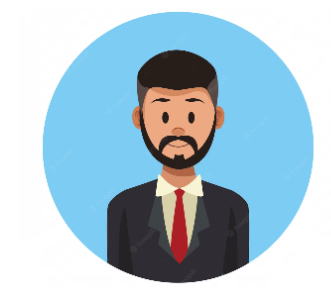

We have a data scientist (Tim) that is starting their first model project. 

Their company's stack involves several different data sources &
 multiple cloud vendors (ex: Azure & AWS). 

Featureform has just been implemented on their cluster & is empty, clean, pristine.
There are no features, training sets, or users.

He prefers to stick to as few languages as possible & use 
Python & SQL for all of their tasks.

Time will connect Featureform to the different providers, data soources he needs and will write the initial set of transformations that will become a V1 dataset that a different data scientist will extend with additional features & data.

## `Tim` Will Connect To The [Infrastructure Providers](https://docs.featureform.com/getting-started/registering-infrastructure-providers)



> *Featureform coordinates a set of infrastructure providers to act together as a feature store. Before transformations, features, and other resources can be defined, an initial set of providers must be configured. This is done via a Python API and applied via the Featureform CLI.*



💬 In this case,

*   `AWS (EMR + S3)` ➡️ Offline Store = provides dataset storage, transformation capabilities, and training set serving.
*   `Redis `➡️ Inference Store = allows feature values to be looked up at inference time.

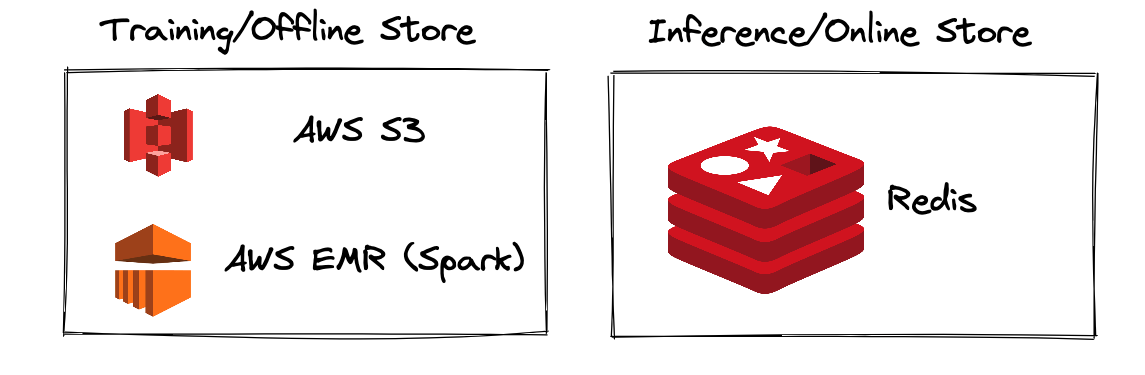

### 📌 Please be sure to check out our ["Providers"](https://docs.featureform.com/getting-started/registering-infrastructure-providers) pages for more information on the credentials needed to connect or "register" different providers.

In [ ]:
redis = ff.register_redis(
    name="redis-quickstart",
    host="<INSERT-HOST>",  # The internal dns name for redis
    port=6379
)

aws_creds = ff.AWSCredentials(
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_KEY
)

emr = ff.EMRCredentials(
    emr_cluster_id="<INSERT-EMR-CLUSTER-ID>",
    emr_cluster_region=AWS_EMR_CLUSTER_REGION,
    credentials=aws_creds,
)

s3 = ff.register_s3(
    name="s3",
    credentials=aws_creds,
    bucket_path="<INSERT-BUCKET-PATH>",
    bucket_region=S3_BUCKET_REGION
)

spark = ff.register_spark(
    name="spark-emr",
    description="A Spark deployment we created for the Featureform quickstart",
    team="<INSERT-TEAM-NAME>",
    executor=emr,
    filestore=s3,
)

## `Tim` Will Connect The [Primary Data Sources](https://docs.featureform.com/getting-started/transforming-data) 
Ex: Parquet Files



> *Once the infrastructure is configured, features and training sets can be created. This begins by registering a set of primary data sources, often followed by defining a DAG of transformations. Once the transformed sources are created, features and training sets can be defined. Other metadata such as descriptions, variants, and names are also defined in this step. In the enterprise editions, governance rules that the organization created will be enforced here. All these steps are done via a Python API and applied via the Featureform CLI.*



We'll be reading in parquet files that include data about payments, orders, customers, and reviews. 

Users can connect [both files and tables](https://docs.featureform.com/getting-started/transforming-data) from databases and buckets (including CSV, etc). 

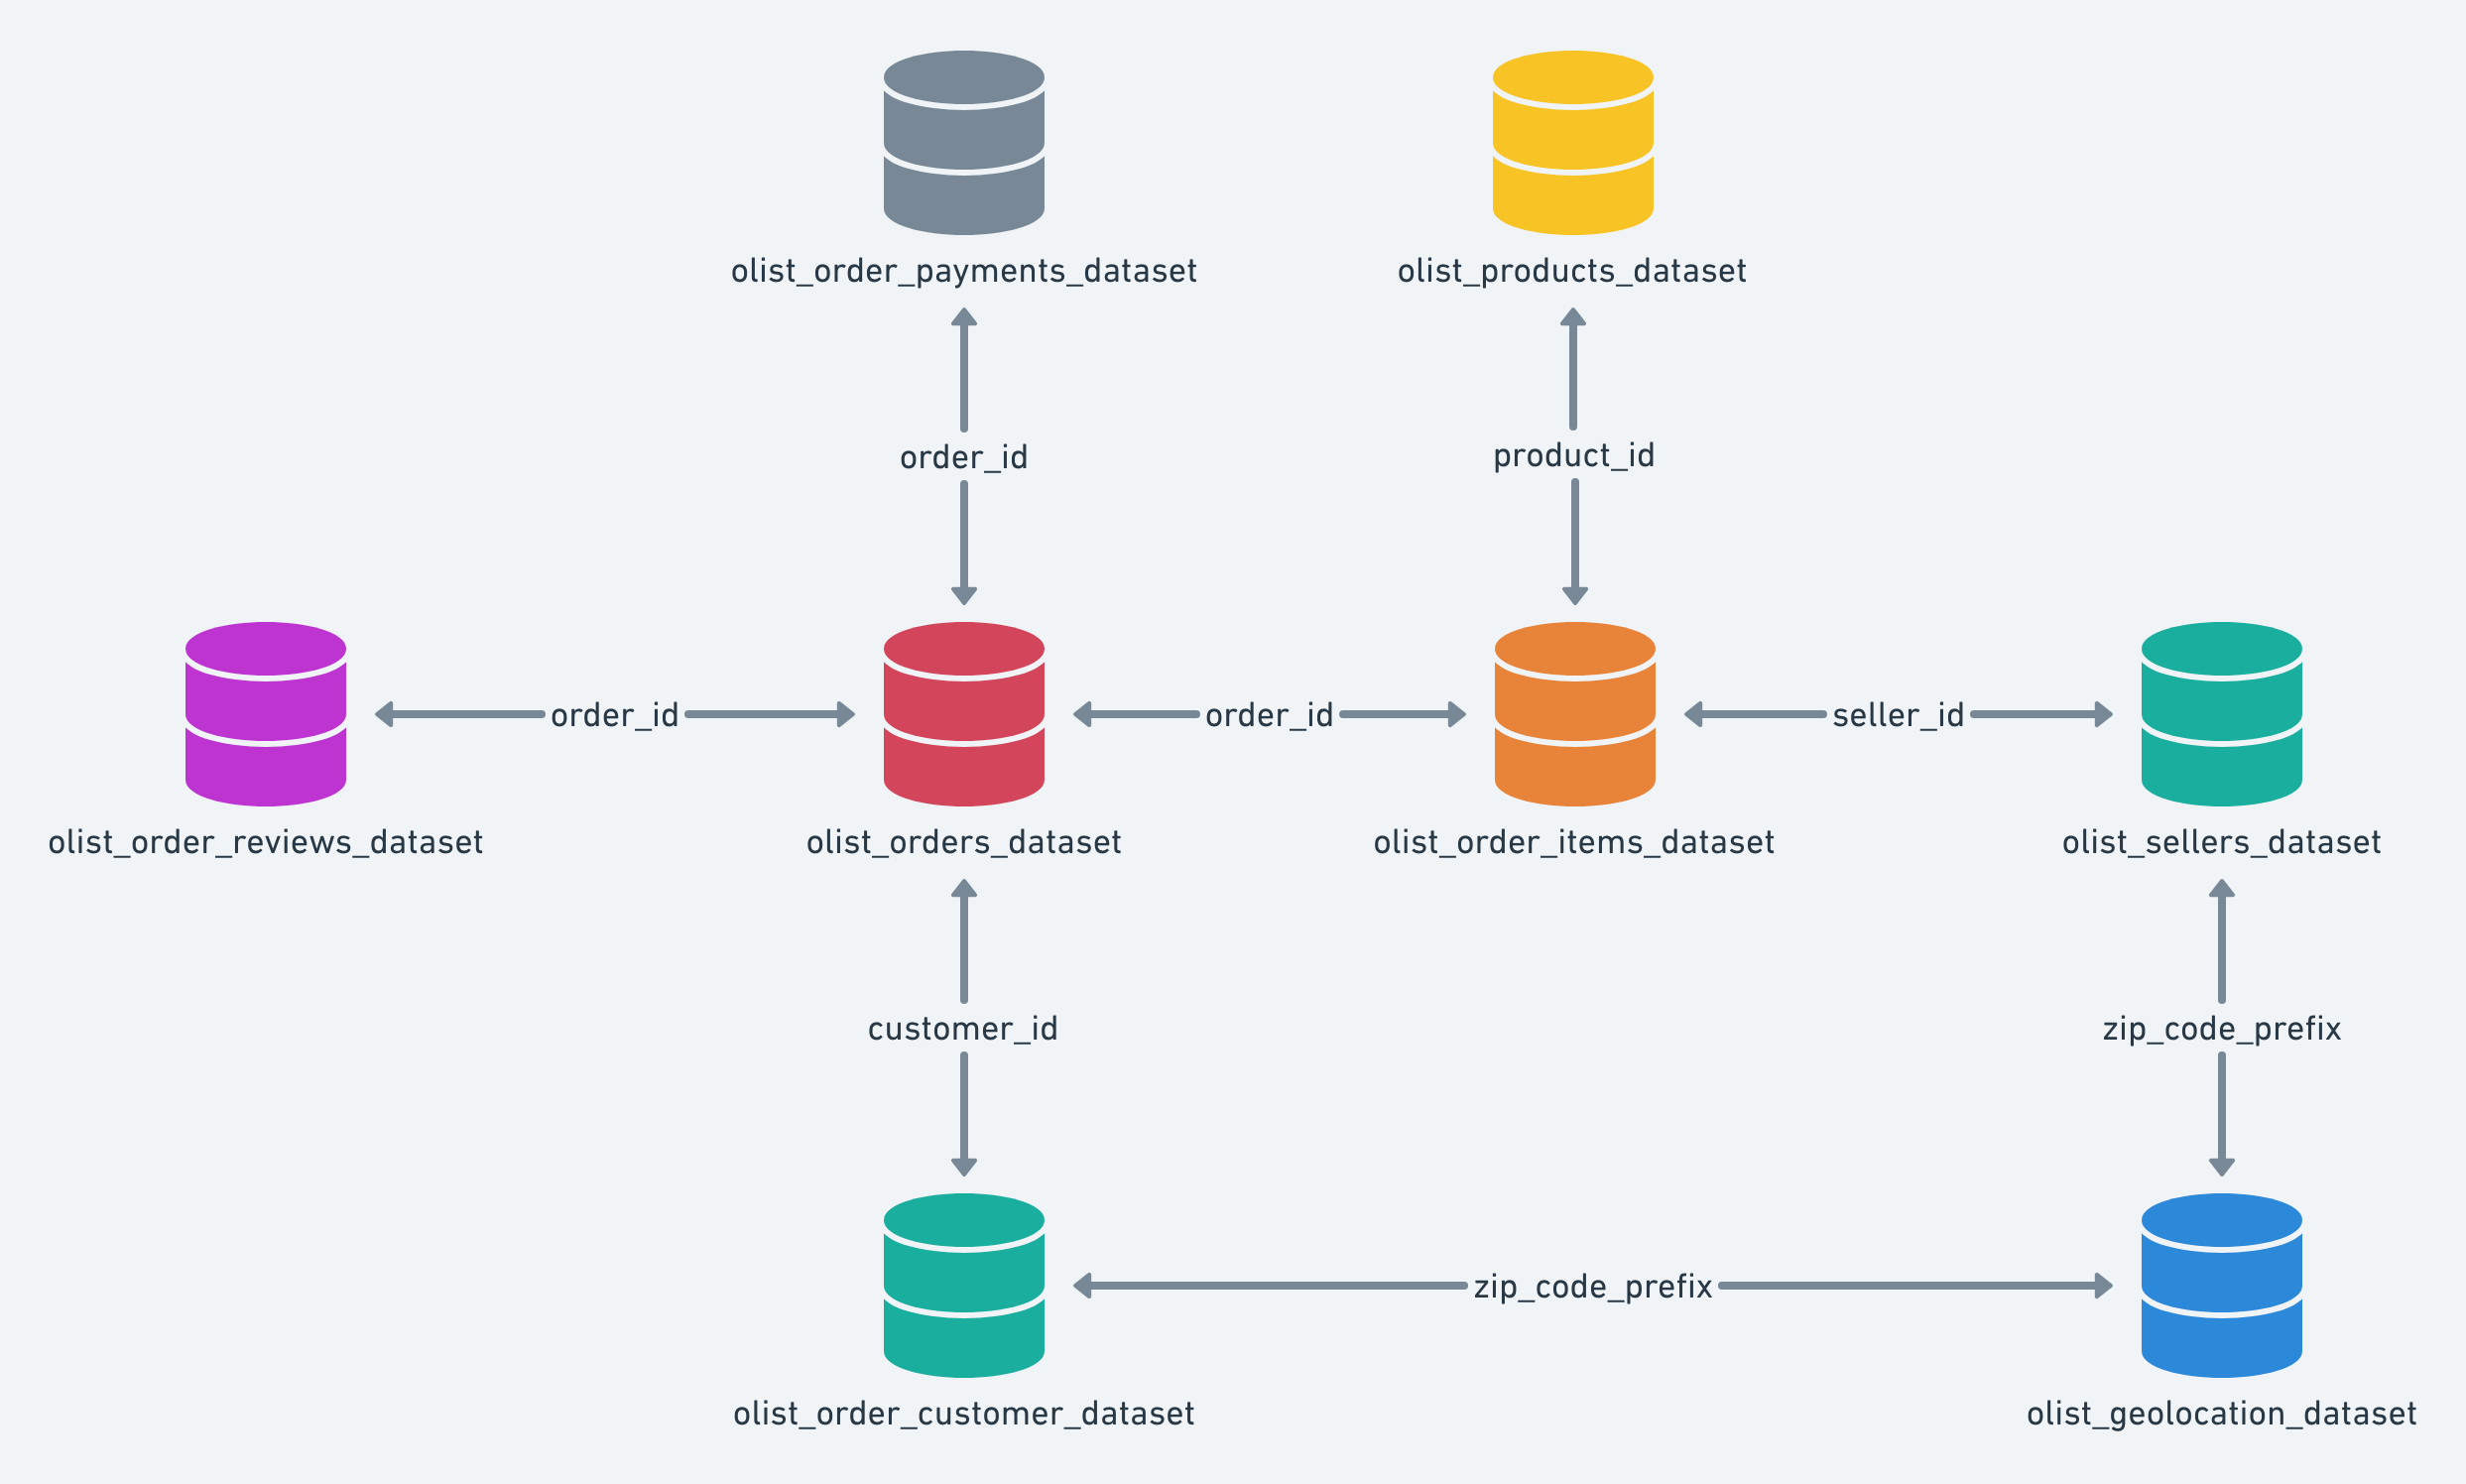

In [ ]:
payments = spark.register_parquet_file(
    name="payments",
    variant="default",
    description="This dataset includes data about the orders payment options.",
    file_path="<INSERT-S3-PATH-TO-DATASET>/brazilian_ecommerce/ecommerce_order_payments_dataset.parquet",
)

In [ ]:
orders = spark.register_parquet_file(
    name="orders",
    variant="default",
    description="This is the core dataset. From each order you might find all other information.",
    file_path="<INSERT-S3-PATH-TO-DATASET>/brazilian_ecommerce/ecommerce_orders_dataset.parquet",
)

In [ ]:
customers = spark.register_parquet_file(
    name="customers",
    variant="default",
    description="This dataset has information about the customer and its location. Use it to identify unique customers in the orders dataset and to find the orders delivery location.",
    file_path="<INSERT-S3-PATH-TO-DATASET>/brazilian_ecommerce/ecommerce_customers_dataset.parquet",
)

### [Register the transformations](https://docs.featureform.com/getting-started/transforming-data)

💬 There are two supported transformation types: SQL and Dataframes. Not all providers support all transformation types. 



> *Each transformation definition also includes a set of metadata like its name, variant, and description.*

#### [SQL Example](https://docs.featureform.com/getting-started/transforming-data#sql): Get total payments per day

In [ ]:
# Get total payments per customer day
@spark.sql_transformation(name="total_paid_per_customer_per_day",
                          variant="default",
                          description="Get the daily total value of payments per customer.")
def total_paid_per_customer_per_day():
    return "select trunc(order_approved_at,'day') as day_date, c.customer_unique_id, sum(p.payment_value) as total_customer_order_paid "\
            "from {{payments.default}} p "\
            "join {{orders.default}} o on (o.order_id = p.order_id) "\
            "join {{customers.default}} c on (c.customer_id = o.customer_id) "\
            "group by 1,2 order by 1 asc "

In [ ]:
# Get total payments per day
@spark.sql_transformation(name="total_paid_per_day",
                          variant="default",
                          description="Get the daily total value of payments.")
def total_paid_per_day():
    return "select trunc(order_approved_at,'day') as day_date, sum(p.payment_value) as total_order_paid "\
            "from {{payments.default}} p "\
            "join {{orders.default}} o on (o.order_id = p.order_id) "\
            "group by 1 order by 1 asc "

### [Dataframes Example](https://docs.featureform.com/getting-started/transforming-data#chaining-transformations): Get average total payments per day

In [ ]:
# Get average order value per day
@spark.df_transformation(inputs=[("total_paid_per_customer_per_day", "default")], variant="default")
def average_daily_transaction(df):
    from pyspark.sql.functions import mean
    return df.groupBy("day_date").agg(mean("total_customer_order_paid").alias("average_order_value"))

### [Transformation DAGs](https://docs.featureform.com/getting-started/transforming-data#chaining-transformations): Getting sum of orders after first month of purchase

Transformations can be daisy chained and can be used as inputs to downstream transformations. 

In [ ]:
# Get month 1 and month 6 dates from earliest purchase
@spark.sql_transformation(name="calculate_month_1_month_6_dates",
                          variant="default",
                          description="Calculate month 1 - 6")
def calculate_month_1_month_6_dates():
    return "select customer_unique_id, to_date(earliest_purchase) as earliest_datetime_purchase, "\
    "date_add(to_date(earliest_purchase),30) as  month_1_datetime, "\
    "date_add(to_date(earliest_purchase),150) as  month_6_datetime "\
    "from (select c.customer_unique_id, min(o.order_approved_at) as earliest_purchase "\
    "from {{orders.default}} o join {{customers.default}} c on (c.customer_id = o.customer_id) group by 1 "\
    "order by customer_unique_id asc "\
    "limit 5000)"

For example, rather than a collection of nested CTE's, we chose to split out calculating dates from calculatign the revenue on those dates. 

Some of the benefits of the modular approach means if the business logic were to change for only one layer of the SQL chain, the rest of the transformations would only need to be updated the with version or `variant` of the same feature.

Whether you choose to write long queries or a series of short modular ones, both styles are possible using Featureform.

In [ ]:
# Get sum of purchases made in first month
@spark.sql_transformation(name="get_month_1_customer_spend",
                          variant="default",
                          description="Get month 1 customer spend")
def get_month_1_customer_spend():
    return "select cm.customer_unique_id, sum(p.payment_value) as month_1_value "\
    "from {{orders.default}} o "\
    "join {{customers.default}} c on (c.customer_id = o.customer_id) "\
    "join {{calculate_month_1_month_6_dates.default}} cm on (cm.customer_unique_id = c.customer_unique_id) "\
    "join {{payments.default}} p on (p.order_id = o.order_id) "\
    "where (to_date(o.order_approved_at) < month_1_datetime) or (to_date(o.order_approved_at) = month_1_datetime) "\
    "group by 1"

In [ ]:
# Get sum of purchases made between months 1 - 6
@spark.sql_transformation(name="get_month_6_customer_spend",
                          variant="default",
                          description="Get month 6 customer spend")
def get_month_6_customer_spend():
    return "select cm.customer_unique_id, sum(p.payment_value) as month_6_value "\
    "from {{orders.default}} o "\
    "join {{customers.default}} c on (c.customer_id = o.customer_id) "\
    "join {{calculate_month_1_month_6_dates.default}} cm on (cm.customer_unique_id = c.customer_unique_id) "\
    "join {{payments.default}} p on (p.order_id = o.order_id) "\
    "where (to_date(o.order_approved_at) < month_6_datetime) "\
    "group by 1"

## `Tim` Will Connect & Link The [Entities, Features and Labels](https://docs.featureform.com/getting-started/defining-features-labels-and-training-sets)

### [Registering entities](https://docs.featureform.com/getting-started/defining-features-labels-and-training-sets#registering-entities): Orders, Customers, Daydate 

💬 Every feature must describe an entity. An entity can be thought of as a primary key table, and every feature must have at least a single foreign key entity field.

> *Common entities include users, items, and purchases. Entities can be anything that a feature can describe.*

In [ ]:
customer = ff.register_entity("customer")

In [ ]:
daydate = ff.register_entity("daydate")

### [Registering features & labels](https://docs.featureform.com/getting-started/defining-features-labels-and-training-sets#registering-features-and-labels): Avg orders, Reviews data, etc

> *Once our entities are specified, we can begin to associate features and labels with them. Features and labels are each made up of at least two columns, an entity column and a value column. Features and labels that change value over time should be linked to a timestamp column as well. The timestamp column also allows us to create [point-in-time correct training data](https://docs.featureform.com/getting-started/defining-features-labels-and-training-sets#point-in-time-correctness).*

**We'll add the daily revenue transformations as features**

In [ ]:
total_paid_per_day.register_resources(
    entity=daydate,
    entity_column="day_date",
    inference_store=redis,
    labels=[
        {"name": "total_order_paid", "variant": "default", "column": "total_order_paid", "type": "float32"},
    ]
)

In [ ]:
average_daily_transaction.register_resources(
    entity=daydate,
    entity_column="day_date",
    inference_store=redis,
    features=[
        {"name": "average_order_value", "variant": "default", "column": "average_order_value", "type": "float32"},
    ],
)

**We'll add the spend columns**

In [ ]:
calculate_month_1_month_6_dates.register_resources(
    entity=customer,
    entity_column="customer_unique_id",
    inference_store=redis,
    features=[
        {"name": "earliest_datetime_purchase", "variant": "default", "column": "earliest_datetime_purchase", "type": "datetime"},
        {"name": "month_1_datetime", "variant": "default", "column": "month_1_datetime", "type": "datetime"},
        {"name": "month_6_datetime", "variant": "default", "column": "month_6_datetime", "type": "datetime"},
    ],
)

In [ ]:
get_month_1_customer_spend.register_resources(
    entity=customer,
    entity_column="customer_unique_id",
    inference_store=redis,
    features=[
        {"name": "month_1_value", "variant": "default", "column": "month_1_value", "type": "float32"},
    ],
)

In [ ]:
get_month_6_customer_spend.register_resources(
    entity=customer,
    entity_column="customer_unique_id",
    inference_store=redis,
    labels=[
        {"name": "month_6_value", "variant": "default", "column": "month_6_value", "type": "float32"},
    ]
)

## `Tim` Will Zip The [Training Sets](): Customer LTV, Sentiment Prediction Training Sets, etc


Now that we know the features we want to use and the labels for prediction, let's get some training sets up and running that we could use for analysis, forecasting, or clustering.



> *Once we have our features and labels registered, we can create a training set. Training set creation works by joining a label with a set of features via their entity value and timestamp. For each row of the label, the entity value is used to look up all of the feature values in the training set. When a timestamp is included in the label and the feature, the training set will contain the latest feature value where the feature's timestamp is less than the label's.*

In [ ]:
ff.register_training_set(
    "customerLTV_training",
    label=("month_6_value"),
    features=["month_1_value"],
)

## `Tim` Will Materialize The Definitions He Created via [`apply`](https://docs.featureform.com/getting-started/interact-with-the-cli#apply-command)

We'll now apply the definitions we've created.

In [ ]:
client.apply()

Creating user default_user
Creating provider redis-quickstart
Creating provider s3
Creating provider spark-emr
Creating source payments
Creating source orders
Creating source customers
Creating source total_paid_per_customer_per_day
Creating source total_paid_per_day
Creating source average_daily_transaction
Creating source calculate_month_1_month_6_dates
Creating source get_month_1_customer_spend
Creating source get_month_6_customer_spend
Creating entity customer
Creating entity daydate
Creating label total_order_paid
Creating feature average_order_value
Creating feature earliest_datetime_purchase
Creating feature month_1_datetime
Creating feature month_6_datetime
Creating feature month_1_value
Creating label month_6_value
Creating training-set customerLTV_training


## 🚃 `Tim` Will [Train a Model With Served Features](https://docs.featureform.com/getting-started/serving-for-inference-and-training) 👩🏻‍🍳

> *Once the training sets and features have been created, they can be served. Featureform provides a Dataset API for training and an Inference API for feature serving.*

💬 When a [training set is defined](https://docs.featureform.com/getting-started/defining-features-labels-and-training-sets#registering-training-sets), it is materialized into the [offline store](https://docs.featureform.com/getting-started/registering-infrastructure-providers#offline-store) associated with the definition. 

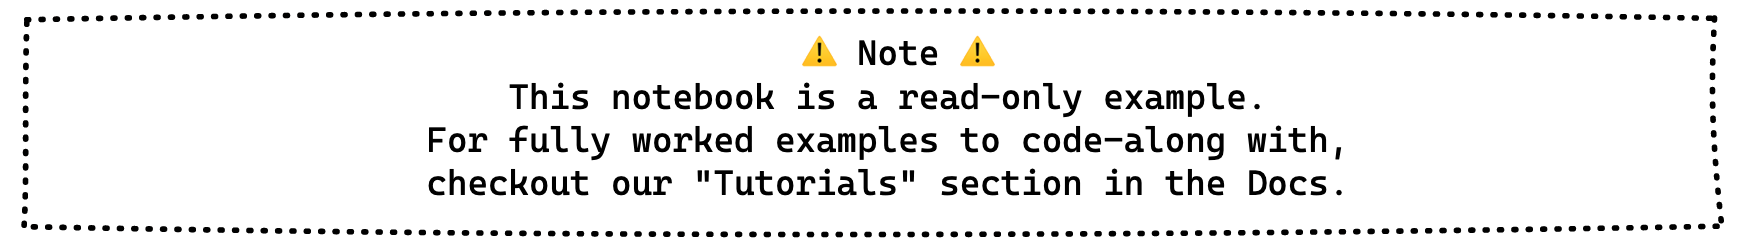

#### Fetch the Training Set via Client

In [ ]:
serving = ff.ServingClient("<INSERT-HOST>")

In [ ]:
dataset = serving.training_set("customerLTV_training", "default")
customerLTV_dataset = dataset.repeat(10).shuffle(1000).batch(10)

#### Train Model 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor()

for batch in customerLTV_dataset:
  regressor.fit(batch.features(), batch.label())
  print("Features:", batch.features()) 
  print("Label:", batch.label())
  print("Prediction:", regressor.predict(batch.features()))
  print("______________________________________________________________")

Features: [array([122.15]), array([122.15]), array([122.15]), array([122.15]), array([122.15]), array([122.15]), array([122.15]), array([122.15]), array([122.15]), array([122.15])]
Label: [122.15, 122.15, 122.15, 122.15, 122.15, 122.15, 122.15, 122.15, 122.15, 122.15]
Prediction: [122.15 122.15 122.15 122.15 122.15 122.15 122.15 122.15 122.15 122.15]
______________________________________________________________
Features: [array([122.15])]
Label: [122.15]
Prediction: [122.15]
______________________________________________________________


### Serve Features for Inference



Customer ID's to try: 



*   0000366f3b9a7992bf8c76cfdf3221e2
*   0000b849f77a49e4a4ce2b2a4ca5be3f
*   00050ab1314c0e55a6ca13cf7181fecf
*   0005ef4cd20d2893f0d9fbd94d3c0d97
*   000a5ad9c4601d2bbdd9ed765d5213b3


feature = serving.features(["feature_name"], {"entity":"entity_value"})









```
feature2 = serving.features([("month_1_value","mikikofake")], {"customer":"0000b849f77a49e4a4ce2b2a4ca5be3f"})

feature3 = serving.features(["month_1_value"], {"customer":"00050ab1314c0e55a6ca13cf7181fecf"})

feature4 = serving.features(["month_1_value"], {"customer":"0005ef4cd20d2893f0d9fbd94d3c0d97"})

feature5 = serving.features(["month_1_value"], {"customer":"000a5ad9c4601d2bbdd9ed765d5213b3"})
```



#  🤝 Collaborating Between Data Scientists Using Featureform 🤝

In the first part of this notebook, Tim did the following:

*   ✅ Connected Featureform to providers like AWS, EMR, Redis, & Spark

*   ✅ Added different Parquet files as sources 

*   ✅ Wrote transformations using Spark SQL & Spark Datafram operations

*   ✅ Chained transformations as DAGs & used curly bracket notation to reference different versions of sources & transformations

*   ✅ "Wrote once, served twice" - Showed how serving features for training & for production inference is as simple as providing a key & specifying whichh model & set of features you'd like to use for specific entities 

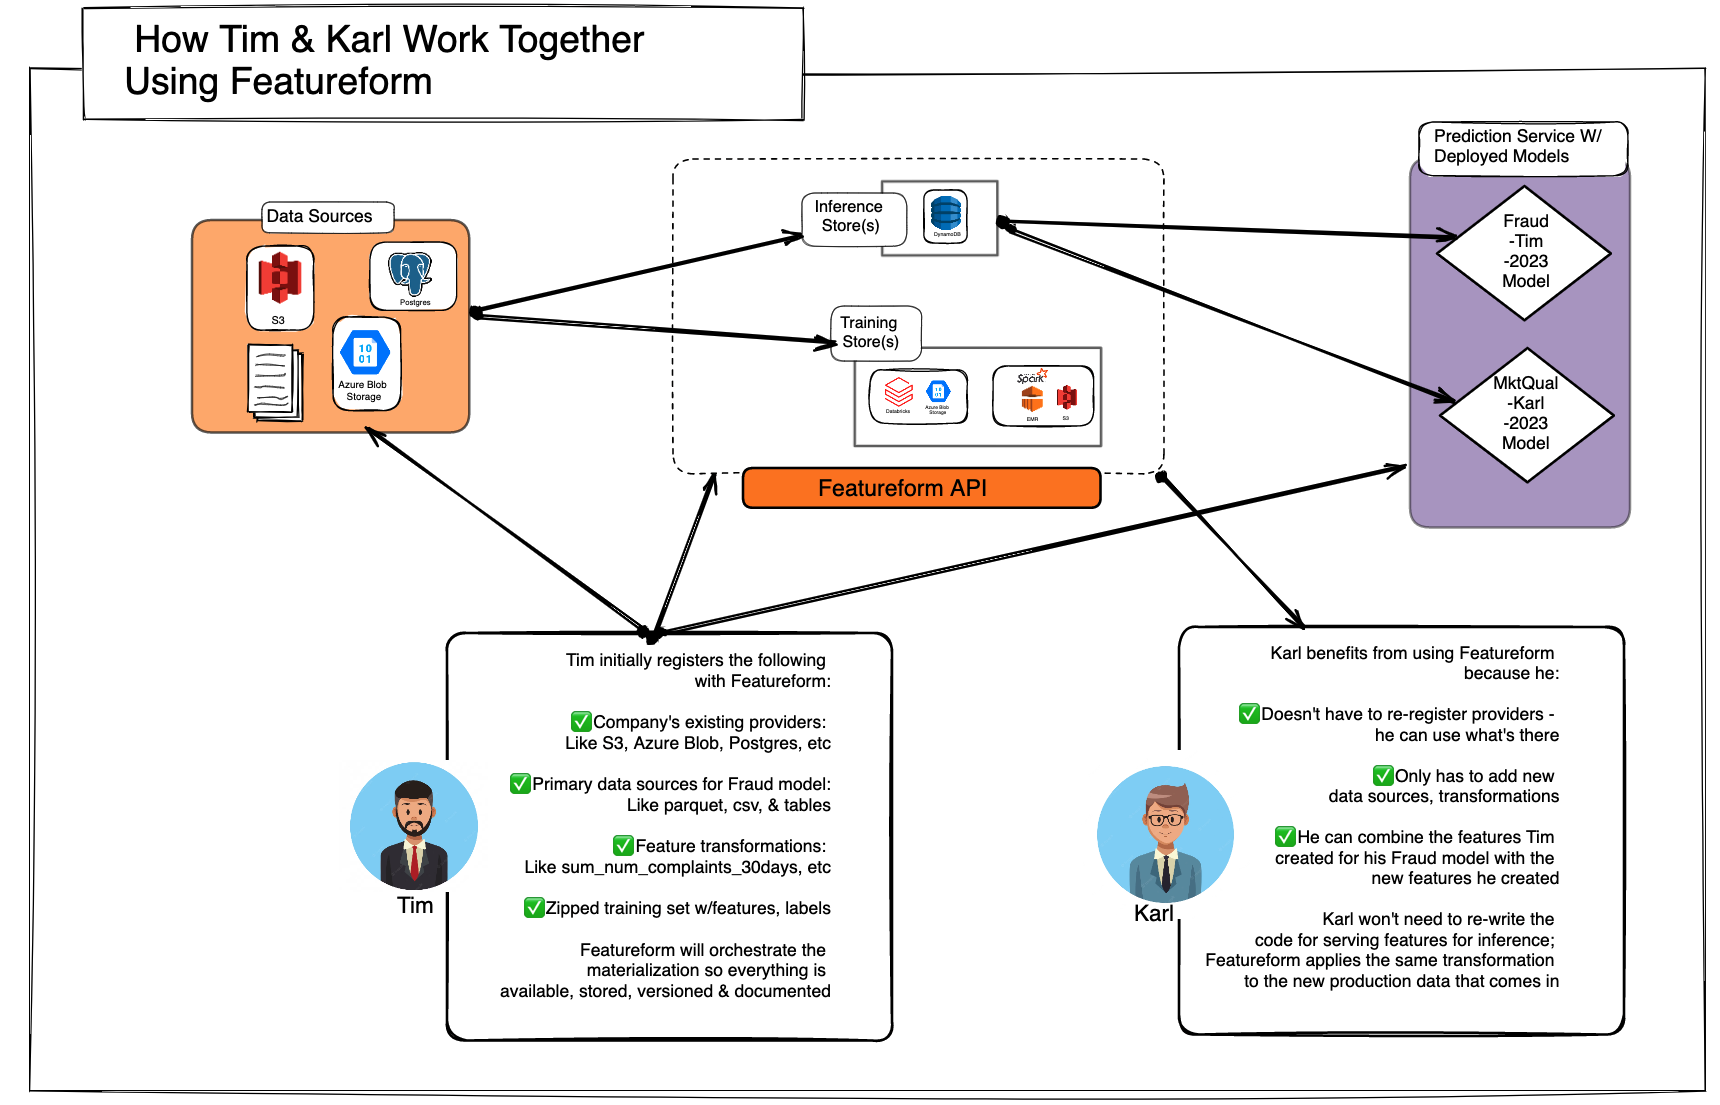

How can Featureform benefit Data Scientists hired after Tim?

# 👋  Data Scientist 2 (`Karl`): Adding New Data Sources & Extending The Good Work of `Tim` 👋

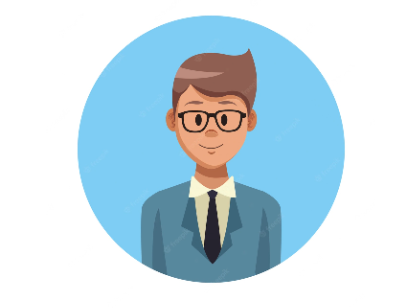

Meet `Karl`. 

`Karl` was just recently hired, 6 months after `Tim`. 

Unlike `Tim`, who works with the finance team, `Karl` was hired as the data scientist for the Marketplace - Product Team.

Some of the same data & features (even a good chunk of the 
training dataset) `Tim` used for his project could be relevant for Karl's project. 

Because `Karl` is using Featureform, he'll be able to:
 

*   ✅ Learn more about the specific logic used for the transformations in `Tim`'s features (as the documentation is captured directly in the Featureform dash); 

*   ✅ Explore other features and datasets data scientists besides `Tim` have generated;

*   ✅ Become aware of any quality issues during serving or transformation (as metrics are captured by Featureform);

*   ✅ Add new variations of features and mix-&-match existing features into new datasets;

*   ✅ Track & version any & all changes to new features throughout the course of his project in a few lines of code.

## `Karl` Will Connect A New Data Source

First, `Karl` has acquired a new dataset, reviews made by customers with a column that has the order id. 

`Karl` will connect Featureform to the new data source.

In [ ]:
reviews = spark.register_parquet_file(
    name="reviews",
    variant="default",
    description="This dataset includes data about the reviews made by the customers.",
    file_path="<INSERT-S3-PATH-TO-DATASET>/brazilian_ecommerce/ecommerce_order_reviews_dataset.parquet",
)

## `Karl` Will Register New Transformations

###  Using unstructured data like text: Getting order reviews



```
#Get reviews and review scores 
@spark.sql_transformation(name="reviews_by_order",
                          variant="default",
                          description="get reviews by order")
def reviews_by_order():
  return "select order_id, review_score, "\
          "concat(review_comment_title, '-',review_comment_message) as review_text " \
          "from {{reviews.default}} r " \
          "where (review_comment_title is not null) and (review_comment_message is not null) " \
          "and (review_comment_title <> '') and (review_comment_message <> '') " \
          "limit 50"
```



In [ ]:
@spark.df_transformation(name="reviews_by_order",
                          variant="default",
                          inputs=[("reviews","default")],
                          description="get reviews by order")
def reviews_by_order(df):
    from pyspark.sql.functions import concat,col
    temp_df = df.filter((col("review_comment_title").isNotNull()) & (col("review_comment_message").isNotNull()))
    return temp_df.select(col("order_id"),col("review_score"), concat(col("review_comment_title"), col("review_comment_message")).alias("review_text"))

We can use get for dataframes (not pictured below). 

`source_customers = ff.get_source("customers","default")`

Notice how we don't have to rewite transformations, we can directly reference an existing, pre-registered transformation and Featureform will automatically populate the mustache

`calculate_month_1_month_6_dates.default`

In [ ]:
# Get sum of purchases made in first month
@spark.sql_transformation(name="get_month_1_avg_review",
                          variant="v5",
                          description="Get month 1 avg review")
def get_month_1_avg_review():
    return "select cm.customer_unique_id, COALESCE(avg(r.review_score), 0) as month_1_review_score "\
    "from {{orders.default}} o "\
    "join {{customers.default}} c on (c.customer_id = o.customer_id) "\
    "join {{calculate_month_1_month_6_dates.default}} cm on (cm.customer_unique_id = c.customer_unique_id) "\
    "join {{reviews.default}} r on (r.order_id = o.order_id) "\
    "where (to_date(o.order_approved_at) < month_1_datetime) or (to_date(o.order_approved_at) = month_1_datetime) "\
    "group by 1"

In [ ]:
# Get average duration of order delivery
@spark.sql_transformation(name="get_month_1_avg_shipping_delay",
                          variant="default",
                          description="Get month 1 avg shipping delay")
def get_month_1_avg_shipping_delay():
    return "select cm.customer_unique_id, avg(datediff(day, o.order_approved_at, o.order_delivered_customer_date)) as month_1_shipping_duration "\
    "from {{orders.default}} o "\
    "join {{customers.default}} c on (c.customer_id = o.customer_id) "\
    "join {{calculate_month_1_month_6_dates.default}} cm on (cm.customer_unique_id = c.customer_unique_id) "\
    "where (to_date(o.order_approved_at) < month_1_datetime) or (to_date(o.order_approved_at) = month_1_datetime) "\
    "group by 1"

In [ ]:
# Get average duration of order delivery
@spark.sql_transformation(name="get_month_1_avg_shipping_delay",
                          variant="mikiko_fake",
                          description="Get month 1 avg shipping delay")
def get_month_1_avg_shipping_delay():
    return "select cm.customer_unique_id, 100.00 as month_1_shipping_duration "\
    "from {{orders.default}} o "\
    "join {{customers.default}} c on (c.customer_id = o.customer_id) "\
    "join {{calculate_month_1_month_6_dates.default}} cm on (cm.customer_unique_id = c.customer_unique_id) "\
    "where (to_date(o.order_approved_at) < month_1_datetime) or (to_date(o.order_approved_at) = month_1_datetime) "\
    "group by 1"

## `Karl` Will Register New Entities, Features and Labels

### Registering entities: Orders, Customers, Daydate 

In [ ]:
customer = ff.get_entity("customer")

In [ ]:
order = ff.register_entity("order")

### Registering features & labels: Avg orders, Reviews data, etc

**We'll add the `review_text` as a feature and `review_score` as a label.**

In [ ]:
reviews_by_order.register_resources(
    entity=order,
    entity_column="order_id",
    inference_store=redis,
    features=[
        {"name": "review_text", "variant": "default", "column": "review_text", "type": "string"},
    ],
    labels=[
        {"name": "review_score", "variant": "default", "column": "review_score", "type": "int"},
    ]
)

In [ ]:
get_month_1_avg_review.register_resources(
    entity=customer,
    entity_column="customer_unique_id",
    inference_store=redis,
    features=[
        {"name": "month_1_review_score", "variant": "default", "column": "month_1_review_score", "type": "float32"},
    ],
)

In [ ]:
get_month_1_avg_shipping_delay.register_resources(
    entity=customer,
    entity_column="customer_unique_id",
    inference_store=redis,
    features=[
        {"name": "month_1_shipping_duration", "variant": "default", "column": "month_1_shipping_duration", "type": "float32"},
        {"name": "month_1_shipping_duration", "variant": "mikiko_fake", "column": "month_1_shipping_duration", "type": "float32"},
    ],
)

## `Karl` Will Zip A Completely New Training Set & Create A new Version of An Existing Training Set

In [ ]:
# This is a completely new training set

ff.register_training_set(
    "sentiment_prediction",
    label=("review_score"),
    features=["review_text"],
)

In [ ]:
# This is a different version of the dataset Tim created earlier
# Karl needs to create a new version because resources are immutable in Featureform
# So no worries about overwriting versions

ff.register_training_set(
    "customerLTV_training",
    variant = "mikiko_training_set", 
    label=("month_6_value"),
    features=["month_1_value", ("month_1_shipping_duration","mikiko_fake")],
)

## `Karl` Will Materialize The Definitions in Featureform through apply

We'll now apply the definitions we've created.

In [ ]:
client.apply()

Creating user default_user
default_user already exists.
Creating provider redis-quickstart
redis-quickstart already exists.
Creating provider s3
s3 already exists.
Creating provider spark-emr
spark-emr already exists.
Creating source payments
payments already exists.
Creating source orders
orders already exists.
Creating source customers
customers already exists.
Creating source total_paid_per_customer_per_day
total_paid_per_customer_per_day already exists.
Creating source total_paid_per_day
total_paid_per_day already exists.
Creating source average_daily_transaction
average_daily_transaction already exists.
Creating source calculate_month_1_month_6_dates
calculate_month_1_month_6_dates already exists.
Creating source get_month_1_customer_spend
get_month_1_customer_spend already exists.
Creating source get_month_6_customer_spend
get_month_6_customer_spend already exists.
Creating entity customer
customer already exists.
Creating entity daydate
daydate already exists.
Creating label tot

## `Karl` Will Train A New Model

 ### Serving Features for Training via Client: Customer LTV Variant

In [ ]:
serving = ff.ServingClient("<INSERT-HOST>")

In [ ]:
dataset = serving.training_set("customerLTV_training", "mikiko_training_set")
customerLTV_dataset = dataset.repeat(1).shuffle(1000).batch(10)

### Train Model 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor()

for batch in customerLTV_dataset:
  print("Features:", batch.features()) 
  print("Label:", batch.label())
  regressor.fit(batch.features(), batch.label())
  print("Prediction:", regressor.predict(batch.features()))
  print("______________________________________________________________")
  
  

Features: [array([  122.15, 10000.  ]), array([  122.15, 10000.  ])]
Label: [122.15, 122.15]
Prediction: [122.15 122.15]
______________________________________________________________


### Serve Features for Inference

Customer ID's to try: 



*   0000366f3b9a7992bf8c76cfdf3221e2
*   0000b849f77a49e4a4ce2b2a4ca5be3f
*   00050ab1314c0e55a6ca13cf7181fecf
*   0005ef4cd20d2893f0d9fbd94d3c0d97
*   000a5ad9c4601d2bbdd9ed765d5213b3


feature = serving.features(["feature_name"], {"entity":"entity_value"})


`feature1 = serving.features(["review_text"], {"order":"df8e5e994bcc820fcf403f9a875201e6"})`